In [1]:
import pandas as pd
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
VARIABLE = 'MonthlyIncome'
VARIABLE2 = 'Monthly income'

PREDICTOR = 'YearsOfEducation'
PREDICTOR2 = 'Years of education'

ALPHA_LEVEL = 0.05

---

Read the data and give it the basic needed structure

In [3]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")

In [4]:
Dat = Dat[[VARIABLE + 'Mean', PREDICTOR]]

In [5]:
PredictorMean = Dat[PREDICTOR].mean()

---

Regression model with common $\alpha$ and $\beta$

In [6]:
with pm.Model() as ModelCommonAlphaCommonBeta:
    Alpha = pm.Flat('Alpha')
    Beta  = pm.Flat('Beta')

    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic('MeanIncome', Alpha + Beta * (Dat[PREDICTOR] - PredictorMean))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma, observed=Dat[VARIABLE + 'Mean'])

Get a sample from the posterior and the posterior predictive

In [7]:
with ModelCommonAlphaCommonBeta:
    TraceCommonAlphaCommonBeta = pm.sample()
    TraceCommonAlphaCommonBeta.extend(pm.sample_posterior_predictive(TraceCommonAlphaCommonBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [Income]


---

National average income, ratio of income per year-of-education

Text(0.5, 1.0, 'National ratio of income per year-of-education, $\\beta$')

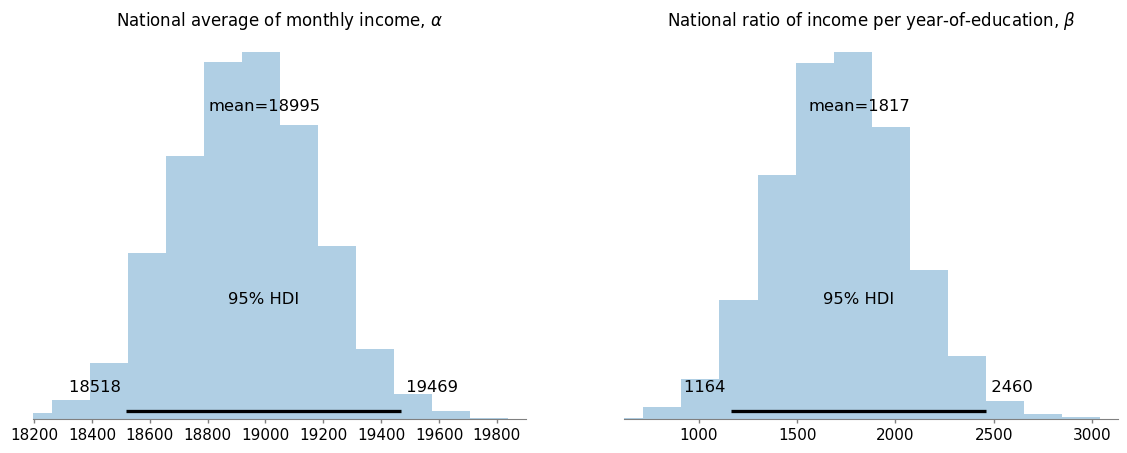

In [8]:
_, axes = plt.subplots(1,2, figsize=(14,5))

az.plot_posterior(
    TraceCommonAlphaCommonBeta
    , var_names = ['Alpha', 'Beta']
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize=11
    , ax = axes
)

axes[0].set_title(r"National average of monthly income, $\alpha$")
axes[1].set_title(r"National ratio of income per year-of-education, $\beta$")

Scatterplot

Text(0.5, 0, 'Years of education')

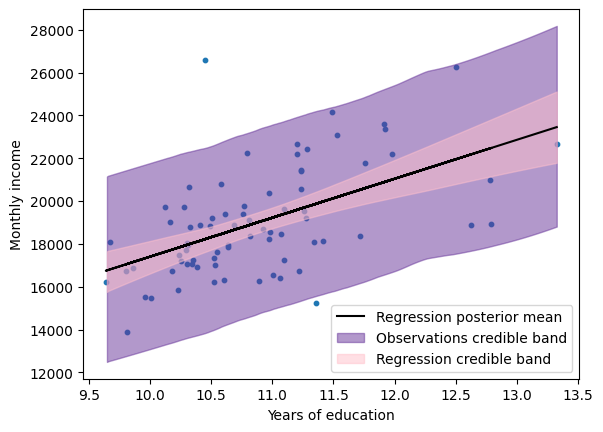

In [9]:
plt.scatter(x=Dat[PREDICTOR], y=Dat[VARIABLE + 'Mean'], s=10)

plt.plot(
    Dat[PREDICTOR]
    , TraceCommonAlphaCommonBeta.posterior.MeanIncome.mean(('chain', 'draw'))
    , label="Regression posterior mean"
    , color='k'
)

az.plot_hdi(
    Dat[PREDICTOR]
    , TraceCommonAlphaCommonBeta.posterior_predictive.Income
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Observations credible band"}
)

az.plot_hdi(
    Dat[PREDICTOR]
    , TraceCommonAlphaCommonBeta.posterior.MeanIncome
    , hdi_prob=1-ALPHA_LEVEL
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':"Regression credible band"}
)

plt.legend()

plt.ylabel(VARIABLE2)
plt.xlabel(PREDICTOR2)